In [6]:
import pandas as pd 
import numpy as np
import datetime
pd.set_option('display.max_columns', None)


#load data
#df_og = pd.read_csv('../../data/127000_rand.csv')

## Functions

In [7]:
def load_data():
    """
    loads sample data extracted from db
    """
    return pd.read_csv('../../data/db_extracts/127000_rand.csv') #change this to the path of file /large_rand.csv 

######Inital Processing######
def remove_rows(df):
    """
    remove outlier rows and certain null values
        - arr_delay outliers above 350 and below -30
        - arr_delay where null
    """

    df = df.loc[(df['arr_delay'].notnull()) | (df['arr_delay'] <= 350)]
    df = df.loc[(df['arr_delay'] <= 350) & (df['arr_delay'] >= -15)]  # play with this
    #df = df.loc[df['taxi_out'] <= 75]
    #df = df.loc[df['taxi_in'] <= 75]

    return df

def create_datetime(df):
    """
    creates columns for month, year, hour onto the dataframe
    """
    df['month'] = pd.DatetimeIndex(df['fl_date']).month
    df['year'] = pd.DatetimeIndex(df['fl_date']).year
    df['day'] = pd.DatetimeIndex(df['fl_date']).dayofweek
    df['dep_hour'] = df['crs_dep_time'].round(-2)/100
    df['arr_hour']= df['crs_arr_time'].round(-2)/100

    return df

def create_is_late(df):
    """
    creates a column 0/1 to indicate if the flight was late or not
    """
    df['is_late'] = df['arr_delay'].apply(lambda x: 1 if x > 0 else 0)

    return df

def create_speed(df):
    """
    create column calculating expected speed of flight. miles/minute
    """
    df['speed'] = (df['distance'] / df['crs_elapsed_time']).round(2)

    return df

def create_route_index(df):
    """
    create key column that combines carrier_origin_dest
    """
    df['route_key'] = df['op_unique_carrier'] + "_" + df['origin_airport_id'].astype('str') + "_" + df['dest_airport_id'].astype('str')
    return df

def create_hot_haul(df):
    """
    categorize short/medium/long haul flights w one-hot encoing
    """
    short = df['crs_elapsed_time'].quantile(0.25)
    med = df['crs_elapsed_time'].quantile(0.85)
    long = df['crs_elapsed_time'].quantile(1)
    df['haul'] = df['crs_elapsed_time'].apply(lambda x: 'short' if (x <= short) else ('medium' if x <= med else 'long'))
    temp = pd.get_dummies(df['haul'], prefix='haul')
    df = pd.concat([df, temp], axis=1)

    return df

def create_reduced_flight_delay_column(df):
    """
    add column showing if arr_delay was < dep_delay
    """
    reduced_delay_flight = df['arr_delay'] < df['dep_delay']
    df['reduced_delay_flight'] = 0
    df.loc[reduced_delay_flight, 'reduced_delay_flight'] = 1

    df['taxi_total'] = df['taxi_in'] + df['taxi_out'] ### Cannot use thisss on the final features table
    return df
 

######Table Creations######

    ## Airports Table ##
def create_table_airports(df):
    """
    input flights table and create a unique airports table with stats that will be used for features later
    """
    df_airports = df.copy()
    df_airports = pd.DataFrame(df['origin_airport_id'])
    df_airports = df_airports.drop_duplicates(subset=['origin_airport_id'])
    df_airports.rename(columns={'origin_airport_id': 'airport_id'}, inplace=True)
    
    
    return df_airports

def create_dep_delay(df_flights, df_airports):
    """
    creates a column showing mean departure delay for each airport
    we used mean because previously have 0d out any negatives and mean results in 0 99% of the time
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').agg('mean')['dep_delay'])
    airports_temp['dep_delay'] = airports_temp['dep_delay'].round(2)
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id'}, inplace=True)

    df_airports = df_airports.merge(airports_temp, on='airport_id')
    df_airports.rename(columns={'dep_delay':'mean_d_delay'}, inplace=True)


    return df_airports

def create_arr_delay(df_flights, df_airports):
    """
    creates a column showing mean arrival delay for each airport
    we used mean because previously have 0d out any negatives and medium results in 0 99% of the time
    """
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').agg('mean')['arr_delay'])
    airports_temp['arr_delay'] = airports_temp['arr_delay'].round(2)
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id'}, inplace=True)

    df_airports = df_airports.merge(airports_temp, on='airport_id')
    df_airports.rename(columns={'arr_delay':'mean_arr_delay'}, inplace=True)

    return df_airports

def create_flight_counts(df_flights, df_airports):
    """
    add columns counting amount of flights in and out of the airports
    this will then be used to calculate a column about % delayed 
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').count()['flights'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'flights':'dep_flight_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')
    
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').count()['flights'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'flights':'arr_flight_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')    
    
    return df_airports

def create_delay_counts(df_flights, df_airports):
    """
    create columns counting number of flights lates for depart and arrival airports
    """
    airports_temp = pd.DataFrame(df_flights.groupby(by='origin_airport_id').agg('sum')['is_late'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'is_late':'dep_late_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')

    airports_temp = pd.DataFrame(df_flights.groupby(by='dest_airport_id').agg('sum')['is_late'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'is_late':'arr_late_count'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')

    return df_airports

def create_late_per(df_airports):
    """
    creates columns showing percent late for arrival and departing airports
    """
    df_airports['dep_late_perc'] = (df_airports['dep_late_count'] / df_airports['dep_flight_count']).round(3)
    df_airports['arr_late_perc'] = (df_airports['arr_late_count'] / df_airports['arr_flight_count']).round(3)

    return df_airports

def create_taxi(df_flights, df_airports):
    """
    add columns shows mean taxi time
    this will then be used to calculate a column about % delayed 
    """
    airports_temp = pd.DataFrame(df_flights.groupby('origin_airport_id').agg('mean')['taxi_out'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'origin_airport_id':'airport_id', 'taxi_out':'dep_taxi'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')
    
    airports_temp = pd.DataFrame(df_flights.groupby('dest_airport_id').agg('mean')['taxi_in'])
    airports_temp.reset_index(inplace=True)
    airports_temp.rename(columns={'dest_airport_id':'airport_id', 'taxi_in':'arr_taxi'}, inplace=True)
    df_airports = df_airports.merge(airports_temp, on='airport_id')    
    
    return df_airports

    ## Tail Number Table ##
def create_tail_table(df_flights):
    """
    creates tabel with tail number stats from flights table
    """
    df_tail = df_flights[['tail_num', 'fl_date', 'is_late', 'arr_delay', 'arr_time', 
                         ]].groupby(by='tail_num').agg({'fl_date':'count', 
                                                                                               'is_late':'sum', 
                                                                                               'arr_delay':['median', 'mean', 'std'],
                                                                                               'arr_time':['median', 'mean'],
                                                                                               })
    df_tail['late_perc'] = (df_tail['is_late']['sum'] / df_tail['fl_date']['count']).round(3)
    
    #flatterning the multi layered headers for easier use later
    flat_cols = list(df_tail.columns.map('_'.join))
    df_tail.columns = flat_cols

    return df_tail

    ## Carrier Table ##
def create_carrier_table(df_flights):
    """
    creates tabel with carrier stats from flights table
    """
    df_carrier = df_flights[['mkt_carrier', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay', 'carrier_delay']].groupby(by='mkt_carrier').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean',
                                                                                           'carrier_delay': 'mean'})
    df_carrier['late_perc'] = (df_carrier['is_late'] / df_carrier['fl_date']).round(3)
    df_carrier['carrier_delay'] = df_carrier['carrier_delay'].round(2)
    df_carrier['dep_delay'] = df_carrier['dep_delay'].round(2)
    df_carrier['arr_delay'] = df_carrier['arr_delay'].round(2)

    return df_carrier
    
def create_carrier_table_v2(df):
    """
    returns new columns for avg taxi in and out based on airports, and total taxi on tail num
    """
    carriers = df.groupby('op_unique_carrier', as_index=False).agg(carrier_arr=('arr_delay', 'mean'), carrier_dep=('dep_delay', 'mean'), carrier_taxiin=('taxi_in', 'mean'), carrier_taxiout=('taxi_out', 'mean'), carrier_late=('is_late', 'sum'), carrier_total=('is_late', 'size'), carrier_reduce_delay=('reduced_delay_flight', 'sum'), reduced_total=('reduced_delay_flight', 'size'))
    carriers['carrier_percent_late'] = carriers['carrier_late'] / carriers['carrier_total'] * 100
    carriers['carrier_taxi_total'] = carriers['carrier_taxiin'] + carriers['carrier_taxiout']
    carriers['percent_carrier_delay_reduced'] = carriers['carrier_reduce_delay'] / carriers['reduced_total'] * 100
    carriers = carriers.drop(columns=['carrier_reduce_delay', 'reduced_total', 'carrier_taxiout', 'carrier_taxiin', 'carrier_total', 'carrier_late'])
    
    #df = df.merge(carriers, on='op_unique_carrier')
    return carriers #df


    ## Hourly Table ##
def create_hourly_table(df_flights):
    """
    creates tabel with hourly stats from flights table
    """
    df_hours = df_flights[['dep_hour', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay']].groupby(by='dep_hour').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean'})
    df_hours['late_perc'] = (df_hours['is_late'] / df_hours['fl_date']).round(3)
    df_hours['dep_delay'] = df_hours['dep_delay'].round(2)
    df_hours['arr_delay'] = df_hours['arr_delay'].round(2)

    return df_hours

    ## Hourly v2 Attempt ##
def create_hourly_table_v2(df):
    """
    second attempt at hourly table
    """
    arr_hourly = df.groupby('arr_hour', as_index=False).agg(arr_hourly_arr=('arr_delay', 'mean'), arr_hourly_dep=('dep_delay', 'mean'), arr_hour_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), ltot=('is_late', 'size'), reduce=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    arr_hourly['arr_hourly_percent_late'] = arr_hourly['late'] / arr_hourly['ltot'] * 100
    arr_hourly['arr_hourly_percent_reduced_delay'] = arr_hourly['reduce'] / arr_hourly['rtot'] * 100
    arr_hourly = arr_hourly.drop(columns=['late', 'ltot', 'reduce', 'rtot'])
    
    dep_hourly = df.groupby('dep_hour', as_index=False).agg(dep_hourly_arr=('arr_delay', 'mean'), dep_hourly_dep=('dep_delay', 'mean'), dep_hourly_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), tot=('is_late', 'size'), red=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    dep_hourly['dep_hourly_percent_late'] = dep_hourly['late'] / dep_hourly['tot'] * 100
    dep_hourly['dep_hourly_percent_reduced'] = dep_hourly['red'] / dep_hourly['rtot'] * 100
    dep_hourly = dep_hourly.drop(columns=['late', 'red', 'tot', 'rtot'])
    
    hourly = pd.concat([arr_hourly, dep_hourly], axis=1).drop('dep_hour', axis=1).rename(columns={'arr_hour':'hour'})

    df.merge(arr_hourly, on='arr_hour')
    df.merge(dep_hourly, on='dep_hour')
    return  hourly #df


    ## Daily Table ##
def create_day_table(df_flights):
    """
    creates tabel with day stats from flights table
    """
    df_days = df_flights[['day', 'fl_date', 'is_late', 
                             'dep_delay', 'arr_delay']].groupby(by='day').agg({'fl_date':'count',
                                                                                           'is_late':'sum',
                                                                                           'dep_delay': 'mean',
                                                                                           'arr_delay': 'mean'})
    df_days['late_perc'] = (df_days['is_late'] / df_days['fl_date']).round(3)
    df_days['dep_delay'] = df_days['dep_delay'].round(2)
    df_days['arr_delay'] = df_days['arr_delay'].round(2)
    
    #bucket carrier category as orginal

    return df_days

def create_day_table_v2(df):
    """
    creates table with weekday stats
    """
    weekday = df.groupby('day', as_index=False).agg(weekday_arr=('arr_delay', 'mean'), weekday_dep=('dep_delay', 'mean'), weekday_taxi=('taxi_total', 'mean'), late=('is_late', 'sum'), tot=('is_late', 'size'), red=('reduced_delay_flight', 'sum'), rtot=('reduced_delay_flight', 'size'))
    weekday['weekday_percent_late'] = weekday['late'] / weekday['tot'] * 100
    weekday['weekday_reduced_delay'] = weekday['red'] / weekday['rtot'] * 100
    weekday = weekday.drop(columns=['red', 'late', 'rtot', 'tot'])

    #df = df.merge(weekday, on='day')
    return weekday 



    ## Route Table ##
def create_route_table(df_flights):
    """
    creates a table with stats about each route for each airline
    """
    routes = df_flights[['route_key', 'dep_delay', 'arr_delay', 'flights']].groupby('route_key').agg({'dep_delay':'mean',
                                                                                              'arr_delay':'mean',
                                                                                              'flights':'count'})
    routes['route_var'] = routes['arr_delay']-routes['dep_delay']
    routes.rename(columns={'dep_delay':'route_dep_delay', 
                           'arr_delay':'route_arr_delay',
                           'flights': 'route_count'}, inplace=True)
    routes.reset_index(inplace=True)
    routes.fillna(0, inplace=True)
    

    return routes


    

###### Exporting Created Tables ######
def save_tables():
    airports.to_csv('../../data/Exported_Tables/stats_airports.csv',  index=False)
    tail.to_csv('../../data/Exported_Tables/stats_tail.csv')
    carrier.to_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly.to_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily.to_csv('../../data/Exported_Tables/stats_daily.csv')
    routes.to_csv('../../data/Exported_Tables/stats_routes.csv', index=False)

def save_tables_combo():
    airports.to_csv('../../data/Exported_Tables/stats_airports.csv',  index=False)
    tail.to_csv('../../data/Exported_Tables/stats_tail.csv')
    carrier.to_csv('../../data/Exported_Tables/stats_carrier.csv')
    carrier_og.to_csv('../../data/Exported_Tables/stats_carrier_og.csv')
    hourly.to_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily.to_csv('../../data/Exported_Tables/stats_daily.csv')
    daily_og.to_csv('../../data/Exported_Tables/stats_daily_og.csv')
    routes.to_csv('../../data/Exported_Tables/stats_routes.csv', index=False)

###### Loading Created Tables ######
def load_f_tables():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv') #index_col='day'
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_old():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv', index_col='mkt_carrier')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv', index_col='day')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_fix():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, hourly, daily, routes

def load_f_tables_combo():
    airports = pd.read_csv('../../data/Exported_Tables/stats_airports.csv')
    tail = pd.read_csv('../../data/Exported_Tables/stats_tail.csv',index_col='tail_num')
    carrier = pd.read_csv('../../data/Exported_Tables/stats_carrier.csv')
    carrier_og = pd.read_csv('../../data/Exported_Tables/stats_carrier_og.csv')
    hourly = pd.read_csv('../../data/Exported_Tables/stats_hourly.csv', index_col='dep_hour')
    daily = pd.read_csv('../../data/Exported_Tables/stats_daily.csv')
    daily_og = pd.read_csv('../../data/Exported_Tables/stats_daily_og.csv', index_col='day')
    routes = pd.read_csv('../../data/Exported_Tables/stats_routes.csv')

    return airports, tail, carrier, carrier_og, hourly, daily, daily_og, routes


###### Mearging Features Onto Origional Table ######

def get_features_airport(df_flights, df_airports):
    """
    merges engineered features from the airport stats table onto the main dataframe as additional columns
    """
    airport_dep = df_airports[['airport_id', 'mean_d_delay', 'dep_late_perc', 'dep_taxi']].rename(columns={'mean_d_delay':'air_mean_d_delay', 'dep_late_perc':'air_dep_late_perc', 'dep_taxi':'air_dep_taxi'})
    airport_arr = df_airports[['airport_id', 'mean_arr_delay', 'arr_late_perc', 'arr_taxi']].rename(columns={'mean_arr_delay':'air_mean_arr_delay', 'arr_late_perc':'air_arr_late_perc', 'arr_taxi':'air_arr_taxi'})

    #merge each onto the main dataframe and rename

    df_temp = df_flights.merge(airport_dep, left_on='origin_airport_id', right_on='airport_id')
    df_temp = df_temp.merge(airport_arr, left_on='dest_airport_id', right_on='airport_id')
    df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_hourly(df_flights, df_hourly):
    """
    merges engineered features from the hourly stats table onto the main dataframe as additional columns
    """
    hourly_filter = df_hourly.reset_index()[['dep_hour', 'fl_date', 
                                             'arr_delay', 'late_perc']].rename(columns={'fl_date':'hour_count', 
                                                                                        'arr_delay':'hour_arr_delay',
                                                                                        'late_perc':'hour_late_perc'})
    df_temp = df_flights.merge(hourly_filter, left_on='dep_hour', right_on='dep_hour')
    #df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_hourly_v2(df_flights, df_hourly):
    """
    merges engineered features from the hourly stats table onto the main dataframe as additional columns
    """
    hourly_arr = df_hourly[['hour', 'arr_hourly_arr', 'arr_hourly_dep', 
                            'arr_hour_taxi', 'arr_hourly_percent_late', 'arr_hourly_percent_reduced_delay']]

    hourly_dep = df_hourly[['hour', 'dep_hourly_arr', 'dep_hourly_dep', 
                            'dep_hourly_taxi', 'dep_hourly_percent_late', 'dep_hourly_percent_reduced']]

    df_temp = df_flights.merge(hourly_arr, left_on='arr_hour', right_on='hour')
    df_temp = df_temp.merge(hourly_dep, left_on='dep_hour', right_on='hour')
    #df_temp.drop(['airport_id_x', 'airport_id_y'], axis = 1, inplace=True)

    return df_temp

def get_features_tail(df_flights, df_tail):
    """
    merges engineered features from the Tail Num stats table onto the main dataframe as additional columns
    """
    tail_filter = df_tail.reset_index()[['tail_num', 'fl_date_count', 'arr_delay_mean', 'arr_delay_std', 'late_perc_']]
    tail_filter.rename(columns={'fl_date_count':'tail_count', 'arr_delay_mean':'tail_arr_delay','arr_delay_std':'tail_arr_delay_std' , 'late_perc_':'tail_late_perc'}, inplace=True)
    tail_filter['tail_arr_delay'] = tail_filter['tail_arr_delay'].round(2)
    tail_filter['tail_arr_delay_std'] = tail_filter['tail_arr_delay_std'].round(2)
    tail_filter.drop('tail_arr_delay_std', axis=1, inplace=True)

    df_output = df_flights.merge(tail_filter, left_on='tail_num', right_on='tail_num')

    return df_output

def get_features_carrier(df_flights, df_carrier):
    """
    merges engineered features from carries
    """
    carrier_filter = df_carrier.reset_index()[['mkt_carrier', 'fl_date', 'arr_delay', 
                                               'carrier_delay', 'late_perc']].rename(columns={'fl_date':'carrier_count', 
                                                                                              'arr_delay':'carrier_arr_delay',
                                                                                              'carrier_delay':'carrier_carrier_delay',
                                                                                              'late_perc':'carrier_late_perc'})
    temp = df_flights.merge(carrier_filter, left_on='mkt_carrier', right_on='mkt_carrier')

    return temp

def get_features_carrier_v2(df_flights, df_carrier):
    """
    merges engineered features from carries
    """
    output = df_flights.merge(df_carrier.drop('Unnamed: 0', axis=1), on='op_unique_carrier')

    return output

def get_features_day(df_flights, df_daily):
    daily_filter = df_daily.reset_index()[['day', 'fl_date', 'dep_delay', 'arr_delay', 
                                            'late_perc']].rename(columns={'fl_date':'day_count', 
                                                                          'dep_delay':'day_dep_delay',
                                                                          'arr_delay':'day_arr_delay',
                                                                          'late_perc':'day_late_perc'})
    
    output = df_flights.merge(daily_filter, left_on='day', right_on='day')

    return output 

def get_features_day_v2(df_flights, df_daily):
    output = df_flights.merge(df_daily.drop('Unnamed: 0', axis=1), on='day')
    return output



def get_features_routes(df_flights, df_routes):
    """
    merges wanted features from the routes table
    """
    output = df_flights.merge(df_routes, on='route_key')
    return output


###### Drop Uneeded Columns ######
def drop_it_og(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num', 
                'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id','origin', 'origin_city_name', 'dest_airport_id',
                'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
                'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code', 'diverted', 'dup', 'actual_elapsed_time', 'air_time', 'flights',
                'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', 
                'longest_add_gtime', 'no_name', 'year', 'route_key', 'is_late', 'haul', 'taxi_total',  'hour_x', 'hour_y'], axis=1)
    return output

def drop_it_old(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier','mkt_carrier_fl_num', 
                'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id','origin', 'origin_city_name', 'dest_airport_id',
                'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 
                'crs_arr_time', 'arr_time', 'cancelled', 'cancellation_code', 'diverted', 'dup', 'actual_elapsed_time', 'air_time', 'flights',
                'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'first_dep_time', 'total_add_gtime', 
                'longest_add_gtime', 'no_name', 'year', 'route_key', 'is_late', 'haul', 'taxi_total'], axis=1)
    return output


def drop_it_fix(df):
    """
    drop unneeded columns to be used in the model
    """
    output = df.copy().drop(['fl_date', 
                'op_unique_carrier', 'tail_num', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'dep_time', 'dep_delay', 
                'taxi_out', 'taxi_in', 'crs_arr_time', 'arr_time', 'actual_elapsed_time', 'year', 'route_key', 'haul',
                'reduced_delay_flight', 'taxi_total', 'flights', ], axis=1)
                # 'hour_x', 'hour_y', is_late
    return output



def save_final_features(df):
    """
    export csv final features table to specificed location
    """
    df.to_csv('../../data/Exported_Tables/final_features.csv')
    return 'Sucessfully exported final features'



###### Transform Jan Test Table ######
def transform_test(data):
    """
    takes the jan test table format and transformes it to a usable state for prediction purposes
    """
    data['dep_hour'] = data['crs_dep_time'].round(-2)/100
    data['arr_hour']= data['crs_arr_time'].round(-2)/100
    #data['speed'] = (data['distance'] / df['crs_elapsed_time']).round(2)
    data['route_key'] = data['op_unique_carrier'] + "_" + data['origin_airport_id'].astype('str') + "_" + data['dest_airport_id'].astype('str')
    data = create_hot_haul(data)

    data = get_features_airport(data, airports)
    data = get_features_hourly(data, hourly)
    data = get_features_tail(data, tail)
    data = get_features_carrier_v2(data, carrier)
    data = get_features_day_v2(data, daily)
    data = get_features_routes(data, routes)
    # data.drop(['fl_date', 'mkt_unique_carrier','branded_code_share','mkt_carrier','mkt_carrier_fl_num',
    #            'op_unique_carrier','tail_num','op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
    #            'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 
    #            'flights', 'route_key'], axis=1, inplace=True)

    return data

# Scrap

# New pipeline w matching Jan keys

In [8]:
def airport_h_avgs(df):
    """
    """
    airports = df.groupby('dest_airport_id', as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    airports['total_percent_late'] = (airports['late'] / airports['total']) * 100
    airports.drop(columns=['total', 'late'], inplace=True)
    airport_weekly_hourly_arr = df.groupby(['dest_airport_id', 'day', 'arr_hour'], as_index=False).agg(airport_weekly_hourly_arr=('arr_delay', 'mean'))
    airport_weekly_hourly_dep = df.groupby(['origin_airport_id', 'day', 'dep_hour'], as_index=False).agg(airport_weekly_hourly_dep=('dep_delay', 'mean'))
    
    airport_hourly_late_arr = df.groupby(['dest_airport_id', 'arr_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    airport_hourly_late_arr['airport_arr_hourly_late_percent'] = airport_hourly_late_arr['late'] / airport_hourly_late_arr['total'] * 100
    airport_hourly_late_dep = df.groupby(['origin_airport_id', 'dep_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    airport_hourly_late_dep['airport_dep_hourly_late_percent'] = airport_hourly_late_dep['late'] /airport_hourly_late_dep['total'] * 100
    
    airport_taxi_arr = df.groupby('dest_airport_id', as_index=False).agg(airport_taxi_in=('taxi_in', 'mean'))
    airport_taxi_dep = df.groupby('origin_airport_id', as_index=False).agg(airport_taxi_out=('taxi_out', 'mean'))
    airport_hourly_late_arr.drop(columns=['total', 'late'], inplace=True)
    airport_hourly_late_dep.drop(columns=['total', 'late'], inplace=True)
    df = df.merge(airport_weekly_hourly_arr, on=['dest_airport_id', 'day', 'arr_hour'])
    df = df.merge(airport_weekly_hourly_dep, on=['origin_airport_id', 'day', 'dep_hour'])
    df = df.merge(airport_hourly_late_arr, on=['dest_airport_id', 'arr_hour'])
    df = df.merge(airport_hourly_late_dep, on=['origin_airport_id', 'dep_hour'])
    df = df.merge(airport_taxi_arr, on=['dest_airport_id'])
    df = df.merge(airport_taxi_dep, on=['origin_airport_id'])
    return df


In [9]:
def carrier_h_avgs(df):
    """
    """
    carrier = df.groupby('op_unique_carrier', as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    carrier['total_percent_late'] = (carrier['late'] / carrier['total']) * 100
    carrier.drop(columns=['total', 'late'], inplace=True)
    carrier_weekly_hourly_arr = df.groupby(['op_unique_carrier', 'dest_airport_id', 'day', 'arr_hour'], as_index=False).agg(carrier_weekly_hourly_arr=('arr_delay', 'mean'))
    carrier_weekly_hourly_dep = df.groupby(['op_unique_carrier', 'origin_airport_id', 'day', 'dep_hour'], as_index=False).agg(carrier_weekly_hourly_dep=('dep_delay', 'mean'))
    
    carrier_hourly_late_arr = df.groupby(['op_unique_carrier', 'dest_airport_id', 'arr_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    carrier_hourly_late_arr['carrier_arr_hourly_late_percent'] = carrier_hourly_late_arr['late'] / carrier_hourly_late_arr['total'] * 100
    carrier_hourly_late_arr.drop(columns=['total', 'late'], inplace=True)
    
    carrier_hourly_late_dep = df.groupby(['op_unique_carrier', 'origin_airport_id', 'dep_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
    carrier_hourly_late_dep['carrier_dep_hourly_late_percent'] = carrier_hourly_late_dep['late'] /carrier_hourly_late_dep['total'] * 100
    carrier_hourly_late_dep.drop(columns=['total', 'late'], inplace=True)


    df = df.merge(carrier_weekly_hourly_arr, on=['op_unique_carrier', 'dest_airport_id', 'day', 'arr_hour'])
    df = df.merge(carrier_weekly_hourly_dep, on=['op_unique_carrier', 'origin_airport_id', 'day', 'dep_hour'])
    df = df.merge(carrier_hourly_late_arr, on=['op_unique_carrier', 'dest_airport_id', 'arr_hour'])
    df = df.merge(carrier_hourly_late_dep, on=['op_unique_carrier', 'origin_airport_id', 'dep_hour'])
    
    return df


In [10]:
df_match = pd.read_csv('../../data/db_extracts/jan_matching_extract.csv')

In [11]:
df_match.shape

(578095, 15)

In [12]:
df_match_t = (
            df_match
            .pipe(remove_rows)
            .pipe(create_datetime)
            .pipe(create_is_late)
            .pipe(create_route_index)
            .pipe(create_hot_haul)
            .pipe(create_reduced_flight_delay_column)
            )
df_match_t['flights'] = 1 
print('---- Proprocessing Complete! ----')

df_match_t = airport_h_avgs(df_match_t)
df_match_t = carrier_h_avgs(df_match_t)

---- Proprocessing Complete! ----


In [13]:


#### TABLE CREATION ####
# create airport table
airports = create_table_airports(df_match_t)
airports = create_dep_delay(df_match_t, airports)
airports = create_arr_delay(df_match_t, airports)
airports = create_flight_counts(df_match_t, airports)
airports = create_delay_counts(df_match_t, airports)
airports = create_late_per(airports)
airports = create_taxi(df_match_t, airports)
print('---- Airport Table Complete! ----')

# create tail numbers table
tail = create_tail_table(df_match_t)
print('---- Tail Table Complete!    ----')

# create carrier table
#carrier = create_carrier_table(df)
carrier = create_carrier_table_v2(df_match_t)
print('---- Carrier Table Complete! ----')

# create hourly table
hourly = create_hourly_table(df_match_t)
#hourly = create_hourly_table_v2(df) #this is version 2    this dude right here is an issueeeee
print('---- hourly Table Complete!  ----')

# create daily table
#daily = create_day_table(df)
daily = create_day_table_v2(df_match_t)
print('---- Daily Table Complete!   ----')
# create routes table
routes = create_route_table(df_match_t)
print('---- Route Table Complete!   ----')

# Export all tables for later use #
save_tables()
print('---- Export Tables Complete! ----')

#### Load Created Tables #####
airports, tail, carrier, hourly, daily, routes = load_f_tables_fix()
print('---- Loading Complete!       ----')


#### MERGING TO DF ##### 
df_merged = df_match_t.copy()
df_merged = get_features_airport(df_merged, airports)
df_merged = get_features_hourly(df_merged, hourly)
#df_merged = get_features_hourly_v2(df_merged, hourly)
df_merged = get_features_tail(df_merged, tail)
#df_merged = get_features_carrier(df_merged, carrier)
df_merged = get_features_carrier_v2(df_merged, carrier)
#df_merged = get_features_day(df_merged, daily)
df_merged = get_features_day_v2(df_merged, daily)
df_merged = get_features_routes(df_merged, routes)
print('---- Merge Complete!         ----')

#### DROP UNEEEDED ####
df_dropped = drop_it_fix(df_merged)
print('---- Final Drop Complete!    ----')

---- Airport Table Complete! ----
---- Tail Table Complete!    ----
---- Carrier Table Complete! ----
---- hourly Table Complete!  ----
---- Daily Table Complete!   ----
---- Route Table Complete!   ----
---- Export Tables Complete! ----
---- Loading Complete!       ----
---- Merge Complete!         ----
---- Final Drop Complete!    ----


In [14]:
df_dropped

,arr_delay,crs_elapsed_time,month,day,dep_hour,arr_hour,is_late,haul_long,haul_medium,haul_short,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep,carrier_arr_hourly_late_percent,carrier_dep_hourly_late_percent,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var
0,-7.0,74.0,9,0,10.0,11.0,0,0,0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,92,11.02,0.500,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
1,8.0,74.0,10,0,10.0,11.0,1,0,0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,90,13.94,0.411,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
2,-13.0,74.0,12,0,22.0,23.0,0,0,0,1,14.161290,13.435484,48.484848,47.094801,6.602127,21.636695,20.857143,9.666667,46.153846,32.432432,14.88,0.474,21.636695,13.65,0.467,6.602127,13963,12.45,0.495,69,12.25,0.522,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
3,-7.0,71.0,9,6,22.0,23.0,0,0,0,1,16.310345,12.528302,48.484848,47.094801,6.602127,21.636695,22.400000,-4.500000,46.153846,32.432432,14.88,0.474,21.636695,13.65,0.467,6.602127,13963,12.45,0.495,66,11.45,0.500,12.460389,13.387579,48.158558,29.812583,61.016884,12.009347,13.680139,26.293311,45.078057,63.848950,12.75,11.5,8,-1.25
4,61.0,74.0,10,4,10.0,11.0,1,0,0,1,9.750000,8.189655,37.735849,42.944785,6.602127,21.636695,10.555556,9.000000,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,101,13.58,0.465,12.460389,13.387579,48.158558,29.812583,61.016884,12.444960,13.895928,26.689810,47.060754,62.343340,12.75,11.5,8,-1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435475,2.0,84.0,5,3,6.0,8.0,1,0,0,1,7.060000,131.000000,27.065527,27.272727,7.448540,19.909091,2.000000,-3.000000,75.000000,100.000000,6.45,0.409,19.909091,6.33,0.404,7.448540,29917,3.14,0.325,100,11.40,0.540,10.796662,11.299718,43.276916,30.442172,59.685002,12.961660,14.107205,26.951515,47.118413,61.371896,-3.00,2.0,1,5.00
435476,-10.0,178.0,1,3,18.0,23.0,0,0,1,0,17.882353,15.048077,54.487179,45.490716,6.653866,19.320864,-10.000000,9.684211,0.000000,41.322314,12.34,0.439,19.320864,9.89,0.451,6.653866,28127,19.41,0.542,106,22.61,0.557,10.796662,11.299718,43.276916,30.442172,59.685002,12.961660,14.107205,26.951515,47.118413,61.371896,-10.00,-10.0,1,0.00
435477,-2.0,22.0,2,3,10.0,10.0,0,0,0,1,-2.000000,-0.181818,33.333333,32.183908,2.631579,10.308612,-2.000000,-10.000000,33.333333,0.000000,2.52,0.405,10.308612,-0.93,0.233,2.631579,28174,8.31,0.413,141,12.86,0.447,10.533333,9.218519,43.703704,12.307143,41.481481,12.961660,14.107205,26.951515,47.118413,61.371896,-10.00,-2.0,1,8.00
435478,-10.0,37.0,2,3,16.0,17.0,0,0,0,1,-3.250000,1.411765,37.037037,37.391304,5.716751,10.308612,-10.000000,-14.000000,0.000000,0.000000,2.52,0.405,10.308612,1.05,0.323,5.716751,26640,16.70,0.512,141,12.86,0.447,10.533333,9.218519,43.703704,12.307143,41.481481,12.961660,14.107205,26.951515,47.118413,61.371896,-11.50,-9.5,2,2.00


In [15]:
df_dropped.to_csv('../../data/Exported_Tables/is_late_train.csv')

In [16]:
df_dropped.dropna(inplace=True)

In [17]:
df_dropped

,arr_delay,crs_elapsed_time,month,day,dep_hour,arr_hour,is_late,haul_long,haul_medium,haul_short,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep,carrier_arr_hourly_late_percent,carrier_dep_hourly_late_percent,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var
0,-7.0,74.0,9,0,10.0,11.0,0,0,0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,92,11.02,0.500,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
1,8.0,74.0,10,0,10.0,11.0,1,0,0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,90,13.94,0.411,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
2,-13.0,74.0,12,0,22.0,23.0,0,0,0,1,14.161290,13.435484,48.484848,47.094801,6.602127,21.636695,20.857143,9.666667,46.153846,32.432432,14.88,0.474,21.636695,13.65,0.467,6.602127,13963,12.45,0.495,69,12.25,0.522,12.460389,13.387579,48.158558,29.812583,61.016884,13.086150,14.464957,26.826750,46.202405,62.297449,12.75,11.5,8,-1.25
3,-7.0,71.0,9,6,22.0,23.0,0,0,0,1,16.310345,12.528302,48.484848,47.094801,6.602127,21.636695,22.400000,-4.500000,46.153846,32.432432,14.88,0.474,21.636695,13.65,0.467,6.602127,13963,12.45,0.495,66,11.45,0.500,12.460389,13.387579,48.158558,29.812583,61.016884,12.009347,13.680139,26.293311,45.078057,63.848950,12.75,11.5,8,-1.25
4,61.0,74.0,10,4,10.0,11.0,1,0,0,1,9.750000,8.189655,37.735849,42.944785,6.602127,21.636695,10.555556,9.000000,30.303030,35.802469,14.88,0.474,21.636695,13.65,0.467,6.602127,28174,8.31,0.413,101,13.58,0.465,12.460389,13.387579,48.158558,29.812583,61.016884,12.444960,13.895928,26.689810,47.060754,62.343340,12.75,11.5,8,-1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435475,2.0,84.0,5,3,6.0,8.0,1,0,0,1,7.060000,131.000000,27.065527,27.272727,7.448540,19.909091,2.000000,-3.000000,75.000000,100.000000,6.45,0.409,19.909091,6.33,0.404,7.448540,29917,3.14,0.325,100,11.40,0.540,10.796662,11.299718,43.276916,30.442172,59.685002,12.961660,14.107205,26.951515,47.118413,61.371896,-3.00,2.0,1,5.00
435476,-10.0,178.0,1,3,18.0,23.0,0,0,1,0,17.882353,15.048077,54.487179,45.490716,6.653866,19.320864,-10.000000,9.684211,0.000000,41.322314,12.34,0.439,19.320864,9.89,0.451,6.653866,28127,19.41,0.542,106,22.61,0.557,10.796662,11.299718,43.276916,30.442172,59.685002,12.961660,14.107205,26.951515,47.118413,61.371896,-10.00,-10.0,1,0.00
435477,-2.0,22.0,2,3,10.0,10.0,0,0,0,1,-2.000000,-0.181818,33.333333,32.183908,2.631579,10.308612,-2.000000,-10.000000,33.333333,0.000000,2.52,0.405,10.308612,-0.93,0.233,2.631579,28174,8.31,0.413,141,12.86,0.447,10.533333,9.218519,43.703704,12.307143,41.481481,12.961660,14.107205,26.951515,47.118413,61.371896,-10.00,-2.0,1,8.00
435478,-10.0,37.0,2,3,16.0,17.0,0,0,0,1,-3.250000,1.411765,37.037037,37.391304,5.716751,10.308612,-10.000000,-14.000000,0.000000,0.000000,2.52,0.405,10.308612,1.05,0.323,5.716751,26640,16.70,0.512,141,12.86,0.447,10.533333,9.218519,43.703704,12.307143,41.481481,12.961660,14.107205,26.951515,47.118413,61.371896,-11.50,-9.5,2,2.00


In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [19]:
df = df_dropped.drop('is_late', axis=1)

X = np.array(df.drop('arr_delay', axis=1))
y = np.array(df['arr_delay'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=69) 

reg = LinearRegression()
reg.fit(X_train,y_train)

print("Train R2:", reg.score(X_train, y_train))
print("Test R2:", reg.score(X_test, y_test))

Train R2: 0.4050536513251777
Test R2: 0.40810617918200554


<AxesSubplot:>

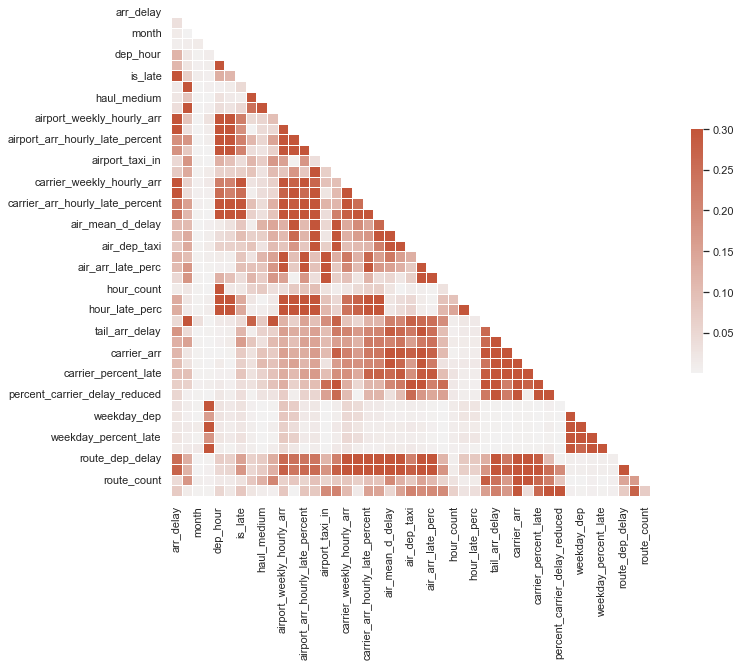

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_dropped.corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
from pycaret.regression import *

In [21]:
clf1 = setup(data = df, target = 'arr_delay', n_jobs=-1)

,Description,Value
0,session_id,7164
1,Target,arr_delay
2,Original Data,"(435465, 45)"
3,Missing Values,False
4,Numeric Features,42
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(304825, 59)"


In [22]:
best = create_model('lr', return_train_score=True)

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
save_model(best, 'best_lr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='arr_delay',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strate...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='arr_delay')),
                 ('fix_perfect', Remove_100(target='arr_delay')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
    

In [23]:
predict_me = pd.read_csv('../../data/model_staging/best_jan_test_ready.csv')
predict_me


,crs_elapsed_time,month,day,dep_hour,arr_hour,haul_long,haul_medium,haul_short,airport_weekly_hourly_arr,airport_weekly_hourly_dep,...,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var
0,95,1,2,18.0,19.0,0,1,0,32.913580,19.214286,...,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000
1,85,1,2,7.0,8.0,0,0,1,10.892857,12.300000,...,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000
2,90,1,2,12.0,13.0,0,0,1,25.983051,4.571429,...,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000
3,85,1,1,18.0,19.0,0,0,1,28.098592,7.777778,...,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.800000,20,-7.250000
4,90,1,1,15.0,16.0,0,0,1,14.574468,4.700000,...,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.800000,20,-7.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126232,147,1,5,18.0,21.0,0,1,0,12.803030,NaN,...,56.074927,9.692946,11.805589,25.563324,42.197381,64.981695,51.00,40.000000,1,-11.000000
126233,115,1,5,16.0,18.0,0,1,0,-3.000000,17.547945,...,56.074927,9.692946,11.805589,25.563324,42.197381,64.981695,4.00,9.000000,1,5.000000
126234,90,1,5,22.0,23.0,0,0,1,-0.160000,8.980769,...,53.202479,9.692946,11.805589,25.563324,42.197381,64.981695,4.80,10.466667,15,5.666667
126235,87,1,5,12.0,14.0,0,0,1,7.368421,17.428571,...,53.202479,9.692946,11.805589,25.563324,42.197381,64.981695,4.80,10.466667,15,5.666667


In [24]:
y_pred = predict_model(best, predict_me)
y_pred

,crs_elapsed_time,month,day,dep_hour,arr_hour,haul_long,haul_medium,haul_short,airport_weekly_hourly_arr,airport_weekly_hourly_dep,...,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,Label
0,95,1,2,18.0,19.0,0,1,0,32.913580,19.214286,...,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000,37.821518
1,85,1,2,7.0,8.0,0,0,1,10.892857,12.300000,...,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000,15.434975
2,90,1,2,12.0,13.0,0,0,1,25.983051,4.571429,...,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.800000,20,-7.250000,8.844411
3,85,1,1,18.0,19.0,0,0,1,28.098592,7.777778,...,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.800000,20,-7.250000,15.707714
4,90,1,1,15.0,16.0,0,0,1,14.574468,4.700000,...,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.800000,20,-7.250000,3.066701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126232,147,1,5,18.0,21.0,0,1,0,12.803030,NaN,...,9.692946,11.805589,25.563324,42.197381,64.981695,51.00,40.000000,1,-11.000000,-1.007497
126233,115,1,5,16.0,18.0,0,1,0,-3.000000,17.547945,...,9.692946,11.805589,25.563324,42.197381,64.981695,4.00,9.000000,1,5.000000,15.991526
126234,90,1,5,22.0,23.0,0,0,1,-0.160000,8.980769,...,9.692946,11.805589,25.563324,42.197381,64.981695,4.80,10.466667,15,5.666667,-6.253075
126235,87,1,5,12.0,14.0,0,0,1,7.368421,17.428571,...,9.692946,11.805589,25.563324,42.197381,64.981695,4.80,10.466667,15,5.666667,65.907387


In [31]:
template = pd.read_csv('../../output/predictions/submission_template.csv').drop('Unnamed: 0', axis=1)
Submission = pd.concat([template, y_pred['Label']], axis=1)
Submission.rename(columns={'Label':'predicted_delay'}, inplace=True)
Submission

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predicted_delay
0,2020-1-1,WN,5888,ONT,SFO,37.821518
1,2020-1-1,WN,5012,ONT,SFO,15.434975
2,2020-1-1,WN,6276,ONT,SFO,8.844411
3,2020-1-7,WN,1794,ONT,SFO,15.707714
4,2020-1-7,WN,1813,ONT,SFO,3.066701
...,...,...,...,...,...,...
126232,2020-1-4,AA,4892,ITH,CLT,-1.007497
126233,2020-1-4,AA,4892,CLT,ITH,15.991526
126234,2020-1-4,UA,4903,IAD,CLE,-6.253075
126235,2020-1-4,UA,4993,IAD,CLE,65.907387


In [32]:
Submission.to_csv('../../output/predictions/best_submission.csv')

# Transforming Test Table

In [113]:
df_jan_test = pd.read_csv('../../data/db_extracts/jan_w1_test.csv')
df_test_transformed = df_jan_test.copy()
df_test_transformed = transform_test(df_test_transformed)


#df_test_transformed.to_csv('../../data/Exported_Tables/X_test_real.csv')

In [114]:
# need to make date column in submission format 
df_test_transformed['year'] = 2020
df_test_transformed['fl_date'] = df_test_transformed['year'].astype('str') + '-' + df_test_transformed['month'].astype('str') + '-' + df_test_transformed['day_om'].astype('str')

#df_submission_template = df_test_transformed[['']]
#df_submission_template = df_test_transformed[['fl_date', 'mkt_carrier', 'mkt_carrier_fl_num', 'origin', 'dest']]

#save template
#df_submission_template.to_csv('../../output/predictions/submission_template.csv')

In [115]:
df_test_transformed['flights'] = 1 
#df_test_transformed = airport_h_avgs(df_test_transformed)
#df_test_transformed = carrier_h_avgs(df_test_transformed)
#hmm because they dont have the 'is_late' value

print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 50)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1


In [116]:
print(df_test_transformed.shape)
df_match_t.head()

(126237, 50)


,fl_date,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,month,year,day,dep_hour,arr_hour,is_late,route_key,haul,haul_long,haul_medium,haul_short,reduced_delay_flight,taxi_total,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep,carrier_arr_hourly_late_percent,carrier_dep_hourly_late_percent
0,2019-09-09,AA,N814AW,11278,14492,1000,953.0,-7.0,18.0,7.0,1114,1107.0,-7.0,74.0,74.0,9,2019,0,10.0,11.0,0,AA_11278_14492,short,0,0,1,0,25.0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469
1,2019-10-28,AA,N823AW,11278,14492,1000,957.0,-3.0,25.0,11.0,1114,1122.0,8.0,74.0,85.0,10,2019,0,10.0,11.0,1,AA_11278_14492,short,0,0,1,0,36.0,1,-0.391304,10.500000,37.735849,42.944785,6.602127,21.636695,-3.000000,4.947368,30.303030,35.802469
2,2019-09-11,AA,N778XF,11278,14492,1000,954.0,-6.0,21.0,6.0,1114,1059.0,-15.0,74.0,65.0,9,2019,2,10.0,11.0,0,AA_11278_14492,short,0,0,1,1,27.0,1,3.685714,6.534091,37.735849,42.944785,6.602127,21.636695,-10.166667,10.166667,30.303030,35.802469
3,2019-10-18,AA,N762US,11278,14492,1000,1112.0,72.0,13.0,6.0,1114,1215.0,61.0,74.0,63.0,10,2019,4,10.0,11.0,1,AA_11278_14492,short,0,0,1,1,19.0,1,9.750000,8.189655,37.735849,42.944785,6.602127,21.636695,10.555556,9.000000,30.303030,35.802469
4,2018-02-05,AA,N352PS,11278,14107,1034,1033.0,-1.0,18.0,6.0,1357,1348.0,-9.0,323.0,315.0,2,2018,0,10.0,14.0,0,AA_11278_14107,long,1,0,0,1,24.0,1,12.229358,10.500000,45.631068,42.944785,7.983357,21.636695,8.026316,4.947368,43.373494,35.802469


In [117]:
temp = df_match_t.groupby(['dest_airport_id', 'day', 'arr_hour'], as_index=False).agg(airport_weekly_hourly_arr=('arr_delay', 'mean'))
#temp['key1'] = temp['dest_airport_id'].astype('str') + temp['day'].astype('str') + temp['arr_hour'].astype('str')
df_test_transformed = df_test_transformed.merge(temp, on=['dest_airport_id', 'day', 'arr_hour'], how='left')

In [118]:
#df_test_transformed['key1'] = df_test_transformed['dest_airport_id'].astype('str') + df_test_transformed['day'].astype('str') + df_test_transformed['arr_hour'].astype('str')
print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 51)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468


In [119]:
airport_weekly_hourly_dep = df_match_t.groupby(['origin_airport_id', 'day', 'dep_hour'], as_index=False).agg(airport_weekly_hourly_dep=('dep_delay', 'mean'))
df_test_transformed = df_test_transformed.merge(airport_weekly_hourly_dep, on=['origin_airport_id', 'day', 'dep_hour'], how='left')

print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 52)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000


In [120]:
df_test_transformed.shape

(126237, 52)

In [121]:
df = df_match_t

airport_hourly_late_arr = df.groupby(['dest_airport_id', 'arr_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
airport_hourly_late_arr['airport_arr_hourly_late_percent'] = airport_hourly_late_arr['late'] / airport_hourly_late_arr['total'] * 100
airport_hourly_late_arr.drop(columns=['total', 'late'], inplace=True)
df_test_transformed = df_test_transformed.merge(airport_hourly_late_arr, on=['dest_airport_id', 'arr_hour'], how='left')
print(df_test_transformed.shape)



(126237, 53)


In [122]:
airport_hourly_late_dep = df.groupby(['origin_airport_id', 'dep_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
airport_hourly_late_dep['airport_dep_hourly_late_percent'] = airport_hourly_late_dep['late'] /airport_hourly_late_dep['total'] * 100
airport_hourly_late_dep.drop(columns=['total', 'late'], inplace=True)
df_test_transformed = df_test_transformed.merge(airport_hourly_late_dep, on=['origin_airport_id', 'dep_hour'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()


(126237, 54)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255


In [123]:
airport_taxi_arr = df.groupby('dest_airport_id', as_index=False).agg(airport_taxi_in=('taxi_in', 'mean'))
df_test_transformed = df_test_transformed.merge(airport_taxi_arr, on=['dest_airport_id'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 55)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209


In [124]:
airport_taxi_dep = df.groupby('origin_airport_id', as_index=False).agg(airport_taxi_out=('taxi_out', 'mean'))
df_test_transformed = df_test_transformed.merge(airport_taxi_dep, on=['origin_airport_id'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 56)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209,11.216412
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209,11.216412
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209,11.216412
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209,11.216412
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209,11.216412


In [125]:
carrier_weekly_hourly_arr = df.groupby(['op_unique_carrier', 'dest_airport_id', 'day', 'arr_hour'], as_index=False).agg(carrier_weekly_hourly_arr=('arr_delay', 'mean'))
df_test_transformed = df_test_transformed.merge(carrier_weekly_hourly_arr, on=['op_unique_carrier', 'dest_airport_id', 'day', 'arr_hour'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()


(126237, 57)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209,11.216412,42.615385
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209,11.216412,14.300000
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209,11.216412,16.250000
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209,11.216412,25.900000
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209,11.216412,15.375000


In [126]:
carrier_weekly_hourly_dep = df.groupby(['op_unique_carrier', 'origin_airport_id', 'day', 'dep_hour'], as_index=False).agg(carrier_weekly_hourly_dep=('dep_delay', 'mean'))
df_test_transformed = df_test_transformed.merge(carrier_weekly_hourly_dep, on=['op_unique_carrier', 'origin_airport_id', 'day', 'dep_hour'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 58)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209,11.216412,42.615385,23.000000
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209,11.216412,14.300000,11.500000
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209,11.216412,16.250000,5.000000
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209,11.216412,25.900000,14.166667
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209,11.216412,15.375000,4.700000


In [127]:
carrier_hourly_late_arr = df.groupby(['op_unique_carrier', 'dest_airport_id', 'arr_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
carrier_hourly_late_arr['carrier_arr_hourly_late_percent'] = carrier_hourly_late_arr['late'] / carrier_hourly_late_arr['total'] * 100
carrier_hourly_late_arr.drop(columns=['total', 'late'], inplace=True)
df_test_transformed = df_test_transformed.merge(carrier_hourly_late_arr, on=['op_unique_carrier', 'dest_airport_id', 'arr_hour'], how='left')
print(df_test_transformed.shape)
df_test_transformed.head()


(126237, 59)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep,carrier_arr_hourly_late_percent
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209,11.216412,42.615385,23.000000,62.337662
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209,11.216412,14.300000,11.500000,40.350877
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209,11.216412,16.250000,5.000000,50.000000
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209,11.216412,25.900000,14.166667,62.337662
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209,11.216412,15.375000,4.700000,63.461538


In [130]:
carrier_hourly_late_dep = df.groupby(['op_unique_carrier', 'origin_airport_id', 'dep_hour'], as_index=False).agg(late=('is_late', 'sum'), total=('is_late', 'size'))
carrier_hourly_late_dep['carrier_dep_hourly_late_percent'] = carrier_hourly_late_dep['late'] /carrier_hourly_late_dep['total'] * 100
carrier_hourly_late_dep.drop(columns=['total', 'late'], inplace=True)

df_test_transformed = df_test_transformed.merge(carrier_hourly_late_dep, on=['op_unique_carrier', 'origin_airport_id', 'dep_hour'], how='left')



In [131]:
print(df_test_transformed.shape)
df_test_transformed.head()

(126237, 60)


,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,op_unique_carrier,tail_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,day_om,day,month,dep_hour,arr_hour,route_key,haul,haul_long,haul_medium,haul_short,air_mean_d_delay,air_dep_late_perc,air_dep_taxi,air_mean_arr_delay,air_arr_late_perc,air_arr_taxi,hour_count,hour_arr_delay,hour_late_perc,tail_count,tail_arr_delay,tail_late_perc,carrier_arr,carrier_dep,carrier_percent_late,carrier_taxi_total,percent_carrier_delay_reduced,weekday_arr,weekday_dep,weekday_taxi,weekday_percent_late,weekday_reduced_delay,route_dep_delay,route_arr_delay,route_count,route_var,year,flights,airport_weekly_hourly_arr,airport_weekly_hourly_dep,airport_arr_hourly_late_percent,airport_dep_hourly_late_percent,airport_taxi_in,airport_taxi_out,carrier_weekly_hourly_arr,carrier_weekly_hourly_dep,carrier_arr_hourly_late_percent,carrier_dep_hourly_late_percent
0,2020-1-1,WN,5888,ONT,SFO,WN,N951WN,13891,14771,1810,1945,95,1,2,1,18.0,19.0,WN_13891_14771,medium,0,1,0,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,131,9.91,0.489,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,32.913580,19.214286,57.866184,42.105263,9.368209,11.216412,42.615385,23.000000,62.337662,50.000000
1,2020-1-1,WN,5012,ONT,SFO,WN,N8537Z,13891,14771,705,830,85,1,2,1,7.0,8.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,26711,5.22,0.364,105,10.67,0.448,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,10.892857,12.300000,40.361446,30.188679,9.368209,11.216412,14.300000,11.500000,40.350877,30.434783
2,2020-1-1,WN,6276,ONT,SFO,WN,N467WN,13891,14771,1150,1320,90,1,2,1,12.0,13.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,29027,10.65,0.439,158,11.39,0.481,7.963065,12.938905,43.300808,18.14179,76.862017,11.171964,12.287895,26.850419,44.399771,61.346661,24.05,16.8,20,-7.25,2020,1,25.983051,4.571429,56.839623,32.584270,9.368209,11.216412,16.250000,5.000000,50.000000,22.580645
3,2020-1-7,WN,1794,ONT,SFO,WN,N268WN,13891,14771,1800,1925,85,7,1,1,18.0,19.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,28127,19.41,0.542,138,5.17,0.457,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,28.098592,7.777778,57.866184,42.105263,9.368209,11.216412,25.900000,14.166667,62.337662,50.000000
4,2020-1-7,WN,1813,ONT,SFO,WN,N475WN,13891,14771,1520,1650,90,7,1,1,15.0,16.0,WN_13891_14771,short,0,0,1,9.09,0.386,11.216412,20.76,0.543,9.368209,25681,15.25,0.494,144,7.33,0.431,7.963065,12.938905,43.300808,18.14179,76.862017,11.531484,12.668137,26.736210,44.380857,61.581985,24.05,16.8,20,-7.25,2020,1,14.574468,4.700000,57.180157,43.137255,9.368209,11.216412,15.375000,4.700000,63.461538,43.750000


In [132]:
df_check = df_dropped.drop(['is_late', 'arr_delay'], axis=1)
df_check.columns

Index(['crs_elapsed_time', 'month', 'day', 'dep_hour', 'arr_hour', 'haul_long',
       'haul_medium', 'haul_short', 'airport_weekly_hourly_arr',
       'airport_weekly_hourly_dep', 'airport_arr_hourly_late_percent',
       'airport_dep_hourly_late_percent', 'airport_taxi_in',
       'airport_taxi_out', 'carrier_weekly_hourly_arr',
       'carrier_weekly_hourly_dep', 'carrier_arr_hourly_late_percent',
       'carrier_dep_hourly_late_percent', 'air_mean_d_delay',
       'air_dep_late_perc', 'air_dep_taxi', 'air_mean_arr_delay',
       'air_arr_late_perc', 'air_arr_taxi', 'hour_count', 'hour_arr_delay',
       'hour_late_perc', 'tail_count', 'tail_arr_delay', 'tail_late_perc',
       'carrier_arr', 'carrier_dep', 'carrier_percent_late',
       'carrier_taxi_total', 'percent_carrier_delay_reduced', 'weekday_arr',
       'weekday_dep', 'weekday_taxi', 'weekday_percent_late',
       'weekday_reduced_delay', 'route_dep_delay', 'route_arr_delay',
       'route_count', 'route_var'],
      dtype

In [134]:
df_ready_to_predict = df_test_transformed[df_check.columns[:]]
df_ready_to_predict.shape

(126237, 44)

In [135]:
df_ready_to_predict.to_csv('../../data/model_staging/best_jan_test_ready.csv', index=False)